In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from langchain_openai import ChatOpenAI

def add(a : int,b : int) -> int:
    """Retuns the sum of two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer."""
    return a + b

def multiply(a : int,b : int) -> int:
    """Retuns the product of two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer."""
    return a * b

def divide(a : int,b : int) -> float:
    """Retuns the division of two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer."""
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model = "gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)



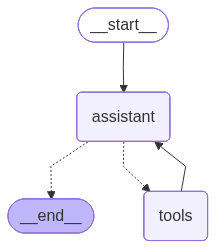

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
input_message =  {"messages": [HumanMessage(content = "Multiply 3 and 4")]}

thread = {"configurable" : {"thread_id" : "1"}}

for event in graph.stream(input_message, config=thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 4


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  multiply (call_qomGmCtlI3wJQC1OQPoafZ5b)
 Call ID: call_qomGmCtlI3wJQC1OQPoafZ5b
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

The product of 3 and 4 is 12.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [11]:
#Looking at prresent state

graph.get_state(thread)


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='1e50ee90-6747-494e-b9b6-4bca7ece1934'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 185, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2NGe21wNHiJK4txXISUiOcfkIyif', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bfbf1-8855-72d3-846f-1f63a4091623-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 4}, 'id': 'call_qomGmCtlI3wJQC1OQPoafZ5b', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 185, 'output_tokens': 

In [14]:
all_state = [s for s in graph.get_state_history(thread)]
all_state[-2] #Last but one state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='1e50ee90-6747-494e-b9b6-4bca7ece1934')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0faf39-e5e8-6e44-8000-1f1e02b44739'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-26T20:14:28.947923+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0faf39-e5e6-6742-bfff-25145d06a708'}}, tasks=(PregelTask(id='ce5f8fac-7e1f-228c-2770-f6e15093b367', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 185, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_predi

### REPLAYING
- We can run our agent from any of the previous states

In [15]:
to_replay = all_state[-2]

In [20]:
to_replay.values, to_replay.next

({'messages': [HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='1e50ee90-6747-494e-b9b6-4bca7ece1934')]},
 ('assistant',))

In [19]:
to_replay.config 

#Shows thread ID and checkpoint ID

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0faf39-e5e8-6e44-8000-1f1e02b44739'}}

In [21]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 4


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  multiply (call_7GfgpfdELU0wHXlykEZ20Sp3)
 Call ID: call_7GfgpfdELU0wHXlykEZ20Sp3
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

The product of 3 and 4 is 12.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### FORKING
- We want to run from a particular state in history but with different input

In [30]:
to_fork = all_state[-2]
to_fork.values["messages"], to_fork.next, to_fork.config


([HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='1e50ee90-6747-494e-b9b6-4bca7ece1934')],
 ('assistant',),
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1f0faf39-e5e8-6e44-8000-1f1e02b44739'}})

In [34]:
fork_config = graph.update_state(to_fork.config, 
                                 {"messages" : [HumanMessage(content="Add 10 and 5", 
                                                                id = to_fork.values["messages"][0].id)]}, 
                                 )

In [35]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0faf5c-2be8-67d6-8001-2aa477b29135'}}

In [ ]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Add 10 and 5


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  add (call_smESEz993AmKeTTTcPCG7Jgq)
 Call ID: call_smESEz993AmKeTTTcPCG7Jgq
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: add

15


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

The sum of 10 and 5 is 15.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [37]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Add 10 and 5', additional_kwargs={}, response_metadata={}, id='1e50ee90-6747-494e-b9b6-4bca7ece1934'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 185, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2NW9gbiAQil0ijH3GGz1y97skSQt', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bfc00-311c-75d2-b726-94feb49b01b7-0', tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 5}, 'id': 'call_smESEz993AmKeTTTcPCG7Jgq', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 185, 'output_tokens': 17, 'tot